In [19]:
import numpy as np
np.random.seed(0)
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [20]:
def g(x):
    return np.tanh(x)

In [21]:
def g_der(x):
    return 1 - g(x) * g(x)

In [22]:
def center(x):
    x = np.array(x)
    mean = x.mean(axis=1, keepdims=True)
    return x - mean

In [23]:
def whitening(x):
    cov = np.cov(x)
    d, E = np.linalg.eigh(cov)
    D = np.diag(d)
    D_inv = np.sqrt(np.linalg.inv(D))
    x_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, x)))
    return x_whiten

In [24]:
 def calculate_new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_der(np.dot(w.T, X)).mean() * w
    w_new /= np.sqrt((w_new ** 2).sum())
    return w_new

In [25]:
def ica(X, iterations, tolerance=1e-5):
    X = center(X)
    X = whitening(X)
    components_nr = X.shape[0]
    W = np.zeros((components_nr, components_nr), dtype=X.dtype)
    for i in range(components_nr):
        w = np.random.rand(components_nr)
        for j in range(iterations):
            w_new = calculate_new_w(w, X)
            if i >= 1:
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            w = w_new
            if distance < tolerance:
                break
        W[i, :] = w
    S = np.dot(W, X)
    return S

In [26]:
def plot_mixture_sources_predictions(X, original_sources, S):
    fig = plt.figure()
    plt.subplot(3, 1, 1)
    for x in X:
        plt.plot(x)
    plt.title("mixtures")

    plt.subplot(3, 1, 2)
    for s in original_sources:
        plt.plot(s)
    plt.title("real sources")

    plt.subplot(3,1,3)
    for s in S:
        plt.plot(s)
    plt.title("predicted sources")

    fig.tight_lay()
    plt.show()

In [27]:
def mix_sources(mixtures, apply_noise=False):
    for i in range(len(mixtures)):
        max_val = np.max(mixtures[i])
        if max_val > 1 or np.min(mixtures[i]) < 1:
            mixtures[i] = mixtures[i] / (max_val / 2) - 0.5

    X = np.c_[[mix for mix in mixtures]]

    if apply_noise:
        X += 0.02 * np.random.normal(size=X.shape)

    return X

In [28]:
n_samples = 2000
time = np.linspace(0, 8, n_samples) #steps of 8/2000 = 0.004 seconds/400 milliseconds
s1 = np.sin(2 * time)
s2 = np.sign(np.sin(3 * time)) # square signal
s3 = signal.sawtooth(2 * np.pi * time)


In [29]:
X = np.c_[s1, s2, s3] #X is 2000x3
A = np.array(([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]))
A.T
# X = np.dot(X, A.T)
# X = X.T
# S = ica(X, iterations=1000)
# actual = mix_sources([s1,s2,s3])
# plot_mixture_sources_predictions(X, [s1, s2, s3], S)

array([[1. , 0.5, 1.5],
       [1. , 2. , 1. ],
       [1. , 1. , 2. ]])

AttributeError: 'Figure' object has no attribute 'tight_lay'

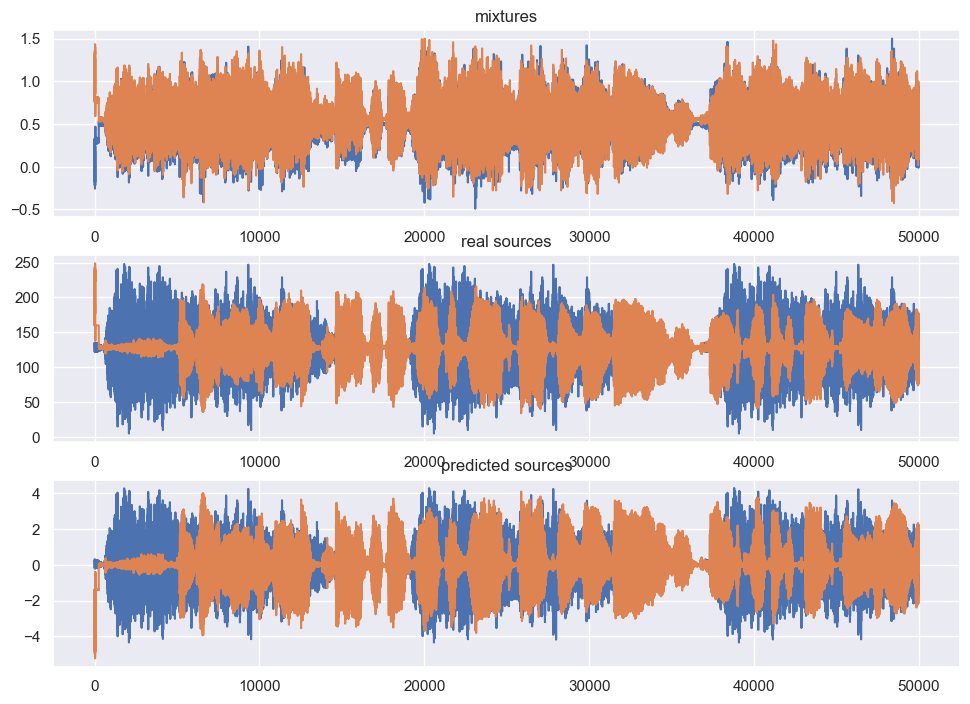

In [30]:
sampling_rate, mix1 = wavfile.read('mix1.wav')
sampling_rate, mix2 = wavfile.read('mix2.wav')
sampling_rate, source1 = wavfile.read('source1.wav')
sampling_rate, source2 = wavfile.read('source2.wav')
actual = mix_sources([source1, source2], False)
X = mix_sources([mix1, mix2])
S = ica(X, iterations=1000)
plot_mixture_sources_predictions(X, [source1, source2], S)
wavfile.write('out1.wav', sampling_rate, S[0])
wavfile.write('out2.wav', sampling_rate, S[1])

C:\Users\fazal\PycharmProjects\Aritificial Intelligence\ICA week 9\venv\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


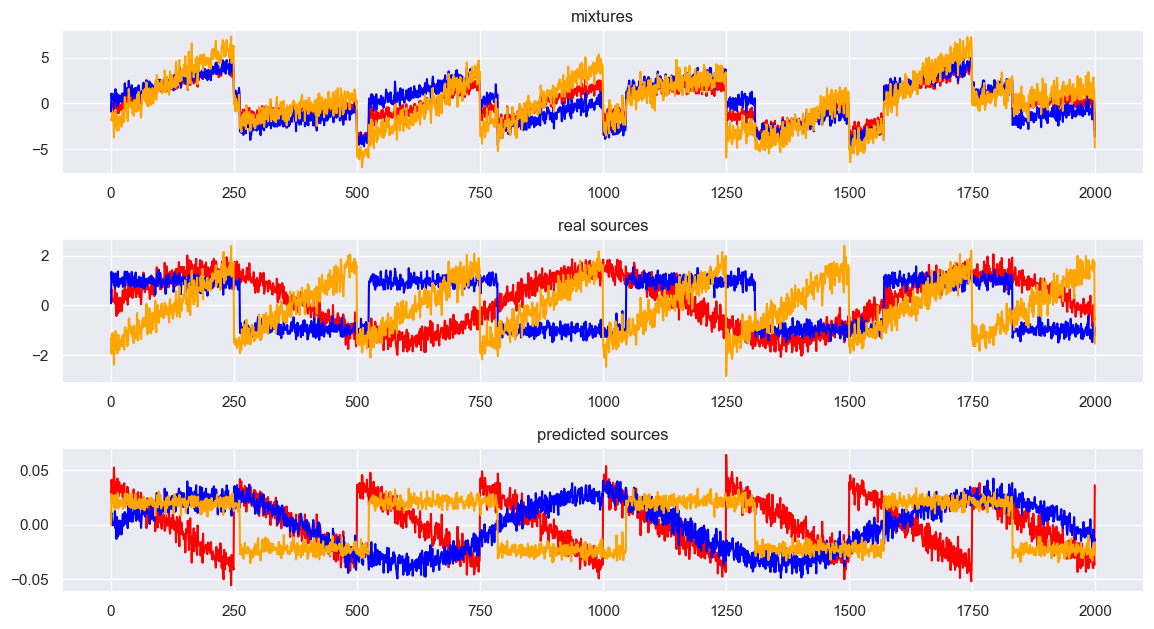

In [31]:
from sklearn.decomposition import FastICA
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)
s2 = np.sign(np.sin(3 * time))
s3 = signal.sawtooth(2 * np.pi * time)

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)
S /= S.std(axis=0)
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])
X = np.dot(S, A.T)

ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)

fig = plt.figure()

models = [X, S, S_]

names = ['mixtures', 'real sources', 'predicted sources']

colors = ['red', 'blue', 'orange']

for i, (name, model) in enumerate(zip(names, models)):
    plt.subplot(4, 1, i+1)
    plt.title(name)
    for sig, color in zip (model.T, colors):
        plt.plot(sig, color=color)

fig.tight_layout()
plt.show()
